# Part 4 - Final Testing of Custom Model

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_dir = os.getcwd()
base_dir

'/kaggle/working'

In [3]:
# Path to the Kaggle input directory
input_dir = '/kaggle/input/samuelsfoodlist3/Samuels Food List'
input_dir

'/kaggle/input/samuelsfoodlist3/Samuels Food List'

In [4]:
train_dir = os.path.join(input_dir, 'train')
validation_dir = os.path.join(input_dir, 'validation')
test_dir = os.path.join(input_dir, 'test')

In [5]:
0

TensorFlow version: 2.13.0
Sat Dec  9 00:26:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [6]:
def unpackPerformance(output, epoch):
    lines = output.split('\n')
    epochs = []
    loss_values = []
    acc = []
    val_loss_values = []
    val_acc = []

    for line in lines:
        words = line.split()
        if "loss" in line:
            loss_values.append(float(words[7]))
            acc.append(float(words[10]))
            val_loss_values.append(float(words[13]))
            val_acc.append(float(words[16]))

    epochs = [i for i in range(1, epoch+1)]
    
    return epochs, loss_values, acc, val_loss_values, val_acc

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotPerformance(epochs, loss_values, acc, val_loss_values, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotFromHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Data Augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = 150

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.35,
    zoom_range=0.35,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=16,
        # Since we use categorical crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=16,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=16,
        class_mode='categorical'
    )

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


### Custom Model and Tuned Hyperparameters

The finalised hyperparameters are:

#### Model Architecture
- Model Architecture consists of conv2D = 64... 128... and multiple feature extractions of 256
- Zero pooling for final feature extraction, conv2D = 512
- Dense layers are 64, 128 and 256 respectively

#### Other Hyperparameters
- Learning rate: 1.9e-4
- Optimiser: Adam
- Batch size: 32
- Data augmentation: 0.35 for both sheer range and zoom range
- Batch normalisation for after every conv2D layer
- Dropout: 0.2
- Spatial dropout: 0.2
- L2 Regularisation: 0.0001
- Replacing Flatten layer with Global Average Pooling (optional)
- Activation function: Gaussian Error Linear Unit (GeLU)

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import ZeroPadding2D, SpatialDropout2D, GlobalAveragePooling2D, Dropout

def createModelDropout(dropout=0.2, l2_reg=0.0001, dense_units=[64, 128, 256], learning_rate=1.3e-4, activation='relu'):
    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation=activation, 
                           input_shape=(150, 150, 3),  kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation=activation, 
                           input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(SpatialDropout2D(dropout))

    model.add(layers.Conv2D(128, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg))) 
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg))) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(SpatialDropout2D(dropout))

    model.add(layers.Conv2D(256, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(SpatialDropout2D(dropout)) 

    model.add(layers.Conv2D(256, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(SpatialDropout2D(dropout)) 

    model.add(ZeroPadding2D((1, 1)))
    model.add(layers.Conv2D(512, (3, 3), activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(SpatialDropout2D(dropout)) 

    model.add(layers.Flatten()) 

    for units in dense_units:
        model.add(layers.Dense(units, activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        model.add(Dropout(dropout))  # Add dropout layer

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  metrics=['acc'])

    model.summary()
    return model


In [23]:
modelFinalGelu1 = createModelDropout(dropout=0.2, l2_reg=0.0001, dense_units=[64, 128, 256], learning_rate=2.5e-4, activation='gelu')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_39 (Ba  (None, 148, 148, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_34 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 batch_normalization_40 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                      

In [24]:
historyGeLU1 = modelFinalGelu1.fit(train_generator,
                              steps_per_epoch=469, #train_sample_size/data_batch_size
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=125)

Epoch 1/100


2023-12-09 05:45:08.914390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/spatial_dropout2d_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 74s 135ms/step - loss: 3.0316 - acc: 0.1252 - val_loss: 5.5503 - val_acc: 0.1120
Epoch 2/100
469/469 [==============================] - 63s 134ms/step - loss: 2.7632 - acc: 0.1444 - val_loss: 2.3945 - val_acc: 0.2390
Epoch 3/100
469/469 [==============================] - 63s 133ms/step - loss: 2.6832 - acc: 0.1565 - val_loss: 2.5141 - val_acc: 0.1915
Epoch 4/100
469/469 [==============================] - 64s 136ms/step - loss: 2.6461 - acc: 0.1581 - val_loss: 2.5818 - val_acc: 0.1950
Epoch 5/100
469/469 [==============================] - 63s 134ms/step - loss: 2.5843 - acc: 0.1643 - val_loss: 2.4154 - val_acc: 0.2200
Epoch 6/100
469/469 [==============================] - 62s 133ms/step - loss: 2.5574 - acc: 0.1779 - val_loss: 2.4518 - val_acc: 0.2100
Epoch 7/100
469/469 [==============================] - 63s 134ms/step - loss: 2.5379 - acc: 0.1804 - val_loss: 2.5668 - val_acc: 0.1920
Epoch 8/100
469/469 [==============================] - 63s 1

In [25]:
historyGeLU2 = modelFinalGelu1.fit(train_generator,
                              steps_per_epoch=469, #train_sample_size/data_batch_size
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=125)

Epoch 1/50
469/469 [==============================] - 65s 139ms/step - loss: 1.3292 - acc: 0.6604 - val_loss: 1.2787 - val_acc: 0.6850
Epoch 2/50
469/469 [==============================] - 65s 139ms/step - loss: 1.3191 - acc: 0.6688 - val_loss: 1.2118 - val_acc: 0.6980
Epoch 3/50
469/469 [==============================] - 66s 140ms/step - loss: 1.3313 - acc: 0.6660 - val_loss: 1.1349 - val_acc: 0.7165
Epoch 4/50
469/469 [==============================] - 66s 140ms/step - loss: 1.2991 - acc: 0.6717 - val_loss: 1.2178 - val_acc: 0.6765
Epoch 5/50
469/469 [==============================] - 66s 140ms/step - loss: 1.3002 - acc: 0.6684 - val_loss: 1.1511 - val_acc: 0.7180
Epoch 6/50
469/469 [==============================] - 66s 140ms/step - loss: 1.2923 - acc: 0.6755 - val_loss: 1.1546 - val_acc: 0.7235
Epoch 7/50
469/469 [==============================] - 66s 141ms/step - loss: 1.2998 - acc: 0.6763 - val_loss: 1.2351 - val_acc: 0.6870
Epoch 8/50
469/469 [==============================] - 6

In [29]:
historyGeLU3 = modelFinalGelu1.fit(train_generator,
                              steps_per_epoch=469, #train_sample_size/data_batch_size
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=125)

Epoch 1/30
469/469 [==============================] - 67s 142ms/step - loss: 1.1848 - acc: 0.7325 - val_loss: 1.1758 - val_acc: 0.7335
Epoch 2/30
469/469 [==============================] - 66s 141ms/step - loss: 1.1676 - acc: 0.7379 - val_loss: 1.1570 - val_acc: 0.7365
Epoch 3/30
469/469 [==============================] - 65s 139ms/step - loss: 1.1723 - acc: 0.7347 - val_loss: 1.0698 - val_acc: 0.7725
Epoch 4/30
469/469 [==============================] - 65s 139ms/step - loss: 1.1692 - acc: 0.7416 - val_loss: 1.0611 - val_acc: 0.7675
Epoch 5/30
469/469 [==============================] - 65s 139ms/step - loss: 1.1752 - acc: 0.7380 - val_loss: 1.0435 - val_acc: 0.7665
Epoch 6/30
469/469 [==============================] - 67s 142ms/step - loss: 1.1620 - acc: 0.7436 - val_loss: 1.0969 - val_acc: 0.7615
Epoch 7/30
469/469 [==============================] - 66s 141ms/step - loss: 1.1831 - acc: 0.7375 - val_loss: 1.1782 - val_acc: 0.7395
Epoch 8/30
469/469 [==============================] - 6

In [26]:
# Example path
model_path = '/kaggle/working/modelFinalGelu1.h5'
modelFinalGelu1.save(model_path)


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Step 3 – Evaluate the Developed Models using Testing Images

In [30]:
# Load the model 
from tensorflow.keras import models
model = models.load_model('/kaggle/working/modelFinalGelu1.h5')

In [32]:
evaluation = model.evaluate(test_generator)

32/32 [==============================] - 7s 195ms/step - loss: 1.2563 - acc: 0.7080


In [33]:
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Test Accuracy: 0.7080000042915344
Test Loss: 1.256318211555481


Since validaiton accuracy is 78% and test accuracy is 70%, the model overfitted as well by learning train dataset and doing well in validation dataset (more similar patterns to train), but not test.

In [35]:
# Load the food list (in alphabetical order)
with open('/kaggle/input/foodlisttxt/Food_list/8.txt', 'r') as f: # the .txt file which contains a list of food assigned to you
    x = f.readlines()
food_list =[]
for item in x:
    if item == '\n':
        continue        
    else:
        food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['cheesecake', 'chicken_curry', 'cup_cakes', 'frozen_yogurt', 'gyoza', 'hamburger', 'huevos_rancheros', 'peking_duck', 'steak', 'tiramisu']


In [36]:
# Define some related functions for image process and model prediction
from keras.preprocessing.image import load_img, img_to_array
img_size = 150
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

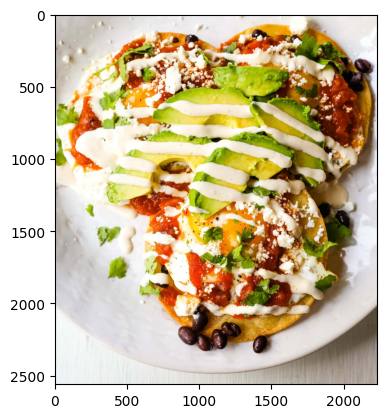

1/1 [==============================] - 1s 676ms/step
The prediction is:  huevos_rancheros 

    cheesecake  chicken_curry  cup_cakes  frozen_yogurt     gyoza  hamburger  \
0    0.002273       0.006367   0.002547       0.000114  0.012518   0.000895   

   huevos_rancheros  peking_duck     steak  tiramisu  
0          0.965792     0.003999  0.004363  0.001132  


In [38]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
import numpy as np
img = '/kaggle/input/imagesinternet/Images_internet/Huevos rancheros.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

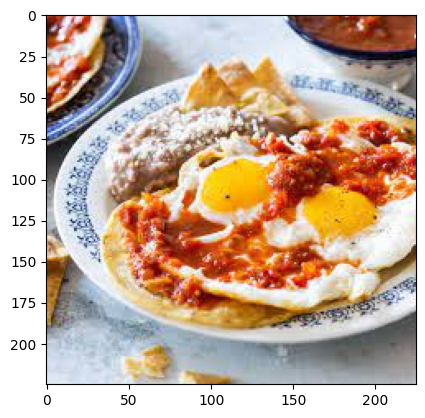

1/1 [==============================] - 0s 26ms/step
The prediction is:  huevos_rancheros 

    cheesecake  chicken_curry  cup_cakes  frozen_yogurt     gyoza  hamburger  \
0    0.010434       0.001997   0.001308       0.000199  0.003013   0.000119   

   huevos_rancheros  peking_duck     steak  tiramisu  
0          0.980016     0.000267  0.000258   0.00239  


In [41]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
import numpy as np
img = '/kaggle/input/imagesinternet/Images_internet/huevos2.jpeg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

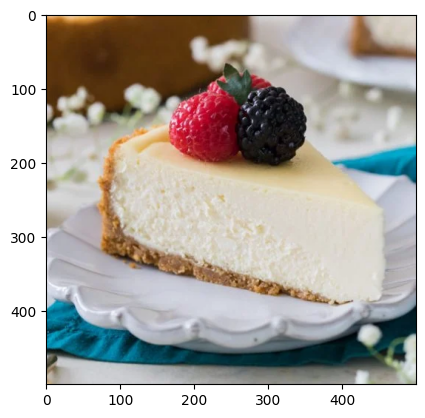

1/1 [==============================] - 0s 26ms/step
The prediction is:  cheesecake 

    cheesecake  chicken_curry  cup_cakes  frozen_yogurt     gyoza  hamburger  \
0    0.986168       0.000378    0.00254       0.000167  0.000196   0.000478   

   huevos_rancheros  peking_duck     steak  tiramisu  
0          0.003187     0.003829  0.001598  0.001458  


In [43]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
import numpy as np
img = '/kaggle/input/imagesinternet/Images_internet/cheesecake.webp' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

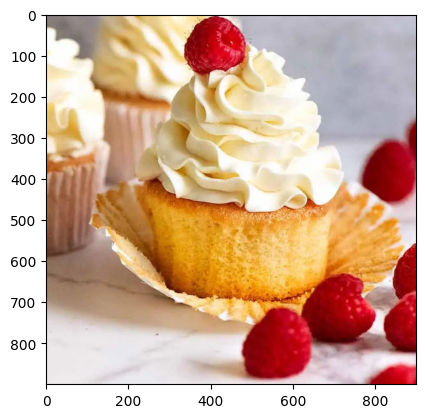

1/1 [==============================] - 0s 25ms/step
The prediction is:  cup_cakes 

    cheesecake  chicken_curry  cup_cakes  frozen_yogurt     gyoza  hamburger  \
0    0.224387       0.004977   0.658321       0.004288  0.018414   0.020511   

   huevos_rancheros  peking_duck     steak  tiramisu  
0          0.052763     0.003043  0.008522  0.004775  


In [45]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
import numpy as np
img = '/kaggle/input/imagesinternet/Images_internet/cupcakes.webp' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

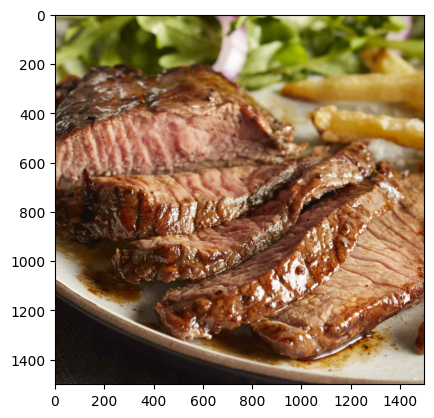

1/1 [==============================] - 0s 25ms/step
The prediction is:  steak 

    cheesecake  chicken_curry  cup_cakes  frozen_yogurt     gyoza  hamburger  \
0     0.00126       0.004082    0.00141        0.00025  0.000216   0.002127   

   huevos_rancheros  peking_duck     steak  tiramisu  
0          0.002263     0.018393  0.964337  0.005661  


In [46]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
import numpy as np
img = '/kaggle/input/imagesinternet/Images_internet/steak.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)